In [1]:
import brainlit
from brainlit.utils.ngl_pipeline import NeuroglancerSession
from brainlit.viz.swc import *
from brainlit.algorithms.generate_fragments import adaptive_thresh

In [2]:
# Optional: Print the IDs of segments in Neuroglancer
url = "s3://mouse-light-viz/precomputed_volumes/brain1"
ngl_skel = NeuroglancerSession(url+"_segments", mip=1)
working_ids = []
for seg_id in range(10): #most segment IDs in range(300), additionally, segments 999, 1000 are available
    try:
        segment = ngl_skel.cv.skeleton.get(seg_id)
        working_ids.append(seg_id)
    except:
          pass
print(working_ids)

Downloading: 100%|██████████| 1/1 [00:00<00:00, 41.18it/s]

[2, 7]


In [3]:
seg_id = 2
mip = 1
df = read_s3(url+"_segments", seg_id, mip)
#df.head()
df['sample'].size # the number of vertex IDs [1, 2, ..., df['sample'].size]

Downloading: 100%|██████████| 1/1 [00:00<00:00, 28.44it/s]
/Users/mattf/Applications/anaconda3/lib/python3.7/site-packages/brainlit/viz/swc.py:45: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  delim_whitespace=True,


1650

In [4]:
print(df)

      sample  structure       x       y       z    r  parent
0          1          0  4713.0  4470.0  3857.0  1.0      -1
1          4        192  4721.0  4445.0  3849.0  1.0       1
2          7         64  4723.0  4446.0  3851.0  1.0       4
3          8          0  4728.0  4449.0  3852.0  1.0       7
4         14          0  4746.0  4445.0  3858.0  1.0       8
5         20        192  4771.0  4431.0  3872.0  1.0      14
6         11         64  4736.0  4461.0  3851.0  1.0       8
7          5          0  4722.0  4454.0  3854.0  1.0       7
8          3          0  4720.0  4475.0  3883.0  1.0       5
9         10          0  4734.0  4485.0  3898.0  1.0       3
10         2          0  4720.0  4530.0  3913.0  1.0      10
11         9          0  4731.0  4585.0  3917.0  1.0       2
12         6          0  4723.0  4435.0  3843.0  1.0       4
13        12          0  4737.0  4410.0  3838.0  1.0       6
14        18          0  4763.0  4369.0  3832.0  1.0      12
15        25          0 

In [5]:
subneuron_df = df[0:5] # choose vertices to use for the subneuron

In [6]:
vertex_list = subneuron_df['sample'].array 

In [7]:
vertex_list

<PandasArray>
[1, 4, 7, 8, 14]
Length: 5, dtype: int64

In [76]:
ngl = NeuroglancerSession(url, mip=mip)
buffer = [10, 10, 10]
img, bounds, vox_in_img_list = ngl.pull_vertex_list(seg_id, vertex_list, buffer = buffer, expand = True)
#img, bounds, voxel = ngl.pull_chunk(2, 100, nx = chunks, ny = chunks, nz = chunks)

Downloading: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]
Downloading: 52it [00:07,  5.35it/s]                        
Downloading: 52it [00:07,  3.24it/s]                        
Downloading: 52it [00:07,  2.44it/s]                        
Downloading: 52it [00:07,  3.44it/s]                        
Downloading: 52it [00:07,  4.84it/s]                        
Downloading: 52it [00:07,  4.78it/s]                        
Downloading: 52it [00:07,  3.34it/s]                        
Downloading: 52it [01:02,  1.02it/s]                        


In [77]:
# Reference: https://github.com/NeuroDataDesign/mouselit/blob/master/bijan/mouse_test/final%20notebook.ipynb

import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
import napari


def plot_2d(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayFromImage(img)
    spacing = img.GetSpacing()

    if nda.ndim == 3:
        c = nda.shape[-1]

        if c not in (3, 4):
            nda = nda[nda.shape[0] // 2, :, :]

    elif nda.ndim == 4:
        c = nda.shape[-1]

        if c not in (3, 4):
            raise RuntimeError("Unable to show 3D-vector Image")

        nda = nda[nda.shape[0] // 2, :, :, :]

    xsize = nda.shape[1] * 2
    ysize = nda.shape[0] * 2

    figsize = (1 + margin) * xsize / dpi, (1 + margin) * ysize / dpi

    plt.figure(figsize=figsize, dpi=dpi, tight_layout=True)
    ax = plt.gca()

    extent = (0, xsize * spacing[0], ysize * spacing[1], 0)

    t = ax.imshow(nda, extent=extent, interpolation=None)

    if nda.ndim == 2:
        t.set_cmap("gray")

    if title:
        plt.title(title)

    plt.show()


def plot_3d(img, xslices=[], yslices=[], zslices=[], title=None, margin=0.05, dpi=80):
    img_xslices = [img[s, :, :] for s in xslices]
    img_yslices = [img[:, s, :] for s in yslices]
    img_zslices = [img[:, :, s] for s in zslices]

    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))

    img_null = sitk.Image([0, 0], img.GetPixelID(), img.GetNumberOfComponentsPerPixel())

    img_slices = []
    d = 0

    if len(img_xslices):
        img_slices += img_xslices + [img_null] * (maxlen - len(img_xslices))
        d += 1

    if len(img_yslices):
        img_slices += img_yslices + [img_null] * (maxlen - len(img_yslices))
        d += 1

    if len(img_zslices):
        img_slices += img_zslices + [img_null] * (maxlen - len(img_zslices))
        d += 1

    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sitk.Tile(img_slices, [maxlen, d])
        else:
            img_comps = []
            for i in range(0, img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sitk.VectorIndexSelectionCast(s, i) for s in img_slices]
                img_comps.append(sitk.Tile(img_slices_c, [maxlen, d]))
            img = sitk.Compose(img_comps)

    plot_2d(img, title, margin, dpi)


def napari_viewer(img, labels=None, shapes=None, label_name="Segmentation"):
    viewer = napari.view_image(np.squeeze(np.array(img)))
    if labels is not None:
        viewer.add_labels(labels, name=label_name)
    if shapes is not None:
        viewer.add_shapes(data=shapes, shape_type='path', edge_color='blue', name='Skeleton')
    return viewer

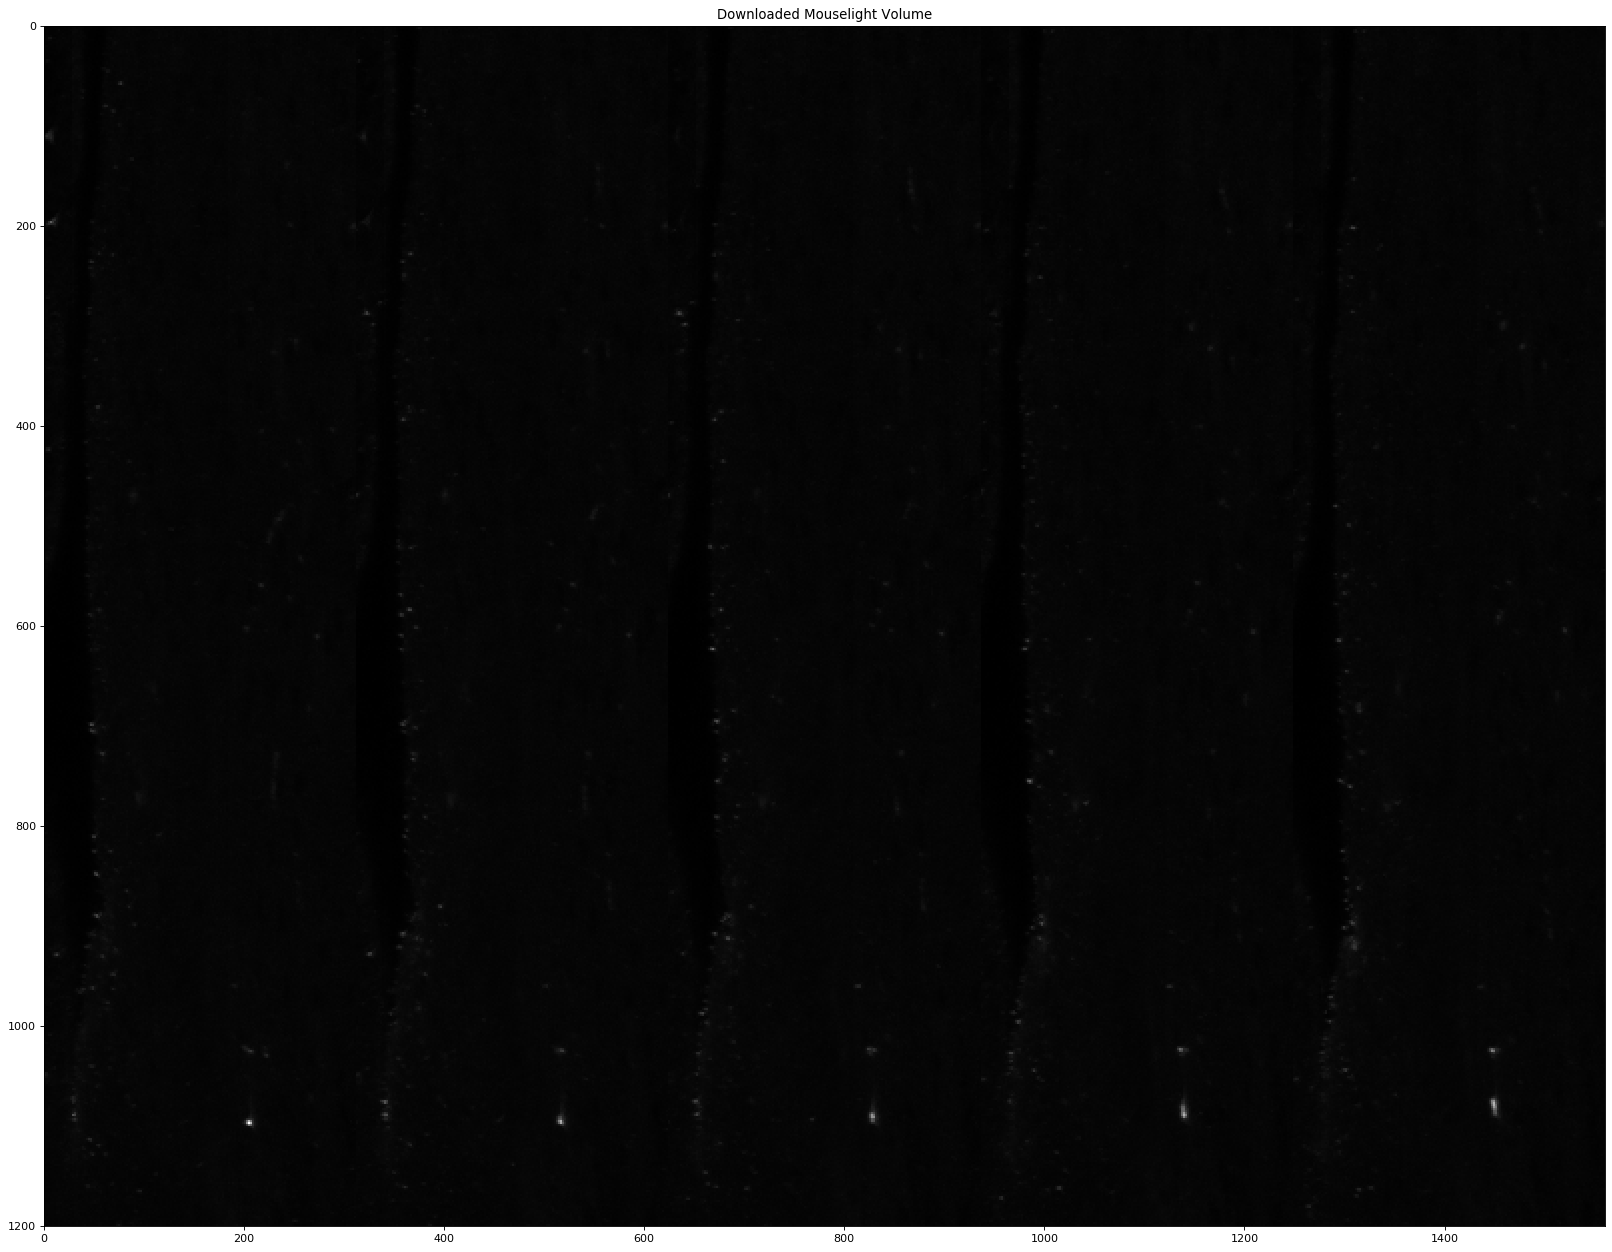

In [78]:
%gui qt
plot_3d(sitk.GetImageFromArray(np.squeeze(img), isVector=False), zslices=range(48,53), title = "Downloaded Mouselight Volume")
napari_viewer(img)

In [79]:
corrected_subneuron_df = subneuron_df
for index, sample in enumerate(vox_in_img_list):
    corrected_subneuron_df['x'][index] = sample[0]
    corrected_subneuron_df['y'][index] = sample[1]
    corrected_subneuron_df['z'][index] = sample[2]
print(corrected_subneuron_df)

/Users/mattf/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mattf/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/mattf/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pa

   sample  structure      x      y      z    r  parent
0       1          0  304.0   71.0  113.0  1.0      -1
1       4        192  299.0   12.0   93.0  1.0       1
2       7         64  335.0   89.0   71.0  1.0       4
3       8          0  222.0  253.0   61.0  1.0       7
4      14          0   46.0  550.0  104.0  1.0       8


In [80]:
G = df_to_graph(corrected_subneuron_df)
print('Number of nodes:', len(G.nodes))
print('Number of edges:', len(G.edges))
print('\n')
print('Sample 1 coordinates (x,y,z)')
G.nodes[1]

Number of nodes: 5
Number of edges: 4


Sample 1 coordinates (x,y,z)


{'x': 304, 'y': 71, 'z': 113}

In [81]:
paths = graph_to_paths(G)
len(paths)

1

In [82]:
%gui qt
napari_viewer(img, shapes=paths)

In [83]:
seed = []
for sample in vox_in_img_list:
    _, s = adaptive_thresh.get_seed(sample)
    seed.append(s)
print(seed)

[(113, 71, 304), (93, 12, 299), (71, 89, 335), (61, 253, 222), (104, 550, 46)]


In [84]:
print(img.shape)

(396, 600, 156)


In [87]:
labels = adaptive_thresh.confidence_connected_threshold(img, seed, num_iter=1, multiplier=0.3)

In [88]:
## Most useful visualization cell - contains image, SWC, and automatic segmentation
%gui qt
napari_viewer(img, labels=labels, shapes=paths, label_name="Confidence-Connected Threshold")

## Steps to Manually Edit Labels
1. Ensure Napari is in 2D-slice viewing, not 3D view. (The second button from the bottom left)
2. Click the image layer and adjust the contrast limits as desired.
3. Click the "Confidence-Connected Threshold Layer"
4. Click the paintbrush tool and adjust the brush size. Ensure that "label" is set to 1 to paint and 0 to erase.
5. Click and drag on the image to adjust labels. Changes are saved automatically, and CMD-Z to undo is supported.

In [89]:
# Get manual labels
manual_labels = viewer.layers['Confidence-Connected Threshold'].data

In [90]:
# Upload segmentation to AWS
ngl_upload = NeuroglancerSession(url+"_seg", mip=mip)

In [93]:
%%capture
ngl_upload.push(manual_labels, bounds);

In [94]:
downloaded_labels = ngl_upload.pull_bounds_seg(bounds)

Downloading: 40it [00:01, 22.71it/s]               6.75it/s]]

Downloading: 48it [00:00, 93.69it/s]                         
Downloading: 52it [00:02, 20.67it/s]                        

Downloading: 44it [00:02, 28.00it/s]                        

Downloading: 52it [00:02, 29.00it/s]                        


In [98]:
print(np.all(manual_labels == downloaded_labels))

True
